In [1]:
import sys

import sklearn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ks_2samp
from sklearn import random_projection
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Нека първо заредим данните и видим с какво разполагаме:

In [2]:
train = pd.read_csv('data/santander-value-prediction-challenge/train.csv')

In [3]:
test = pd.read_csv('data/santander-value-prediction-challenge/test.csv')

In [4]:
pd.options.display.max_rows = 15
pd.read_csv('data/santander-value-prediction-challenge/train.csv')

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
5,002dbeb22,2800000.0,0.0,0,0.0,0,0,0,0,0,...,12000.0,5600000.0,20000000.0,0,0,0,0,0,0,11000
6,003925ac6,164000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,40000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4452,ff7be29d2,400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4453,ff7cdeb16,4000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


Забелязваме 3 неща:
1) Има супер много нулеви (празни) стойности
2) Има повече колони в dataset-a, отколкото редове
3) Имената на колоните и редовете са кодирани

От 1) и 2) можем да заключим, че dataset-a е sparse, а 3) означава че не можем да използваме домейна за да извлечем информация. Ще трябва да работим само с данните, с които разполагаме.

В такъв случай, нека се отървем от ID колоните, и разделим target колоната - тази, която ще предсказваме, от останалите

In [5]:
test_ID = test['ID']
test.drop("ID", axis = 1, inplace = True)

y_train = train['target']
train.drop("ID", axis = 1, inplace = True)
train.drop("target", axis = 1, inplace = True)

Нека видим как изглежда target колоната. За целта ще използваме distplot.

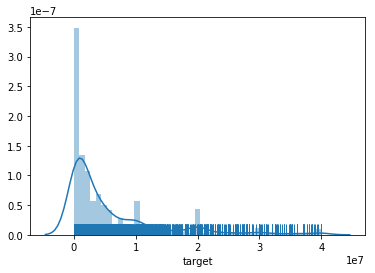

In [6]:
sns.distplot(y_train, rug = "true")

Данните нямат хубаво разпределение - имат "тежка" дясна опашка. Дали няма нещо, което можем да направим по-въпроса? Нека пробваме с логаритмуване.

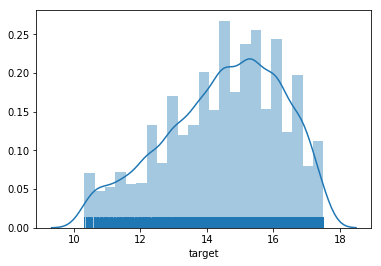

In [7]:
y_train = np.log1p(y_train)
sns.distplot(y_train, rug = "true")

Така изглежда по-добре. Логаритмуваме с log1p, което е еквивалентно на ln(1+x), за да избегнем ненужното изчисление на големи негативни стойности, при 0<x<1.

In [8]:
print(train.columns.size)
print(train.columns[train.nunique() == 1].size)

4991
256


Изглежда има feature-и, които имат само една уникална стойност - вероятно константни нули. Това са колони, които няма да ни предоставят никаква значима информация, и съответно можем безопасно да ги премахнем. 256 от 4991 не е огромен процент, но е старт.

In [9]:
cols_with_onlyone_val = train.columns[train.nunique() == 1]
train.drop(cols_with_onlyone_val.values, axis=1, inplace=True)
test.drop(cols_with_onlyone_val.values, axis=1, inplace=True)

При толкова sparse матрица, има добър шанс освен константни feature-и, да има и дупликиращи се. Нека проверим дали такива съществуват.

In [10]:
columns = train.columns
duplicateCols = []
for i in range(len(columns)-1):
    v = train[columns[i]].values
    for j in range(i + 1,len(columns)):
        if np.array_equal(v, train[columns[j]].values):
            duplicateCols.append(columns[j])
len(duplicateCols)

6

Шест на брой. Off with their heads.

In [11]:
train.drop(duplicateCols, axis=1, inplace=True) 
test.drop(duplicateCols, axis=1, inplace=True) 

//TODO: Check for duplicate rows as well

Това че имаме повече feature-и от редове е предпоставка за overfitting. Едно от нещата, които можем да направим по въпроса, е да използваме само най-важните feature-и в нашият модел.
По долу ще използваме random forest regressor, за да можем да сортираме feature-ите по важност.

In [12]:
NUM_OF_FEATURES = 1000
def root_mean_squared_log_err(y, pred):
    return np.sqrt(np.mean(np.power(y - pred, 2)))

x1, x2, y1, y2 = train_test_split(
    train, y_train.values, test_size=0.20, random_state=42)
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(x1, y1)
print(root_mean_squared_log_err(y2, model.predict(x2)))


1.5188426382478397


note: тук използваме метод на оценка е root mean squared logarithmic error, тъй като прекарахме y_train през логаритмична трансформация.

Нека да визуализираме първите няколко най-важни featurе-и

Feature ranking:
1. feature 4131 (0.081771)
2. feature 3467 (0.031961)
3. feature 4021 (0.028549)
4. feature 2378 (0.020132)
5. feature 3572 (0.016910)
6. feature 8 (0.013601)
7. feature 2616 (0.012093)
8. feature 1459 (0.010541)
9. feature 1484 (0.009963)
10. feature 2082 (0.009514)
11. feature 4029 (0.006523)
12. feature 3792 (0.005993)
13. feature 3868 (0.005989)
14. feature 834 (0.005718)
15. feature 4186 (0.005567)


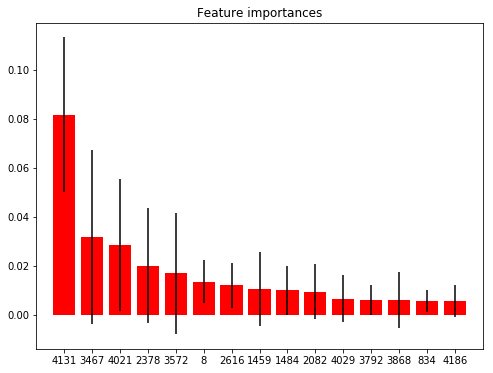

In [13]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices_by_importance = np.argsort(importances)[::-1]

print("Feature ranking:")

FEATURES_TO_PLOT = 15

for f in range(FEATURES_TO_PLOT):
    print("%d. feature %d (%f)" % (f + 1, indices_by_importance[f], importances[indices_by_importance[f]]))

plt.figure(figsize=(8, 6))
plt.title("Feature importances")
plt.bar(range(FEATURES_TO_PLOT), importances[indices_by_importance[:FEATURES_TO_PLOT]],
       color="r", yerr=std[indices_by_importance[:FEATURES_TO_PLOT]], align="center")
plt.xticks(range(FEATURES_TO_PLOT), indices_by_importance)
plt.xlim([-1, FEATURES_TO_PLOT])
plt.show()

Изглежда сякаш първите 15тина feature-a отговарят за 20-25% от точността на модела. Нека да вземем NUM_OF_FEATURES на брой най-важни колони.

In [14]:
col = pd.DataFrame({'importance': model.feature_importances_, 'feature': train.columns}).sort_values(
    by=['importance'], ascending=[False])[:NUM_OF_FEATURES]['feature'].values
train = train[col]
test = test[col]
train.shape

(4459, 1000)

//TODO: Experiment with NUM_OF_FEATURES, to find the best possible value

Добре, дотук имаме NUM_OF_FEATURES най-важни feature-a. Това всичко е добре, обаче поради сравнително голямата разлика между обемите на train и test set-овете, искаме да проверим дали стойностите на всяка колона са еднакво разпределени в тях. Правим това, защото ако разпределението на един feature в train и test сета е различно, то той няма да генерализира добре и съответно няма да ни носи значима информация.
За да проверим това ще използваме Колмогоров-Смирнов статистически тест, който за 2 обема данни, проверява хипотезата дали тяхното разпределение е еднакво. (more info: https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html)

In [15]:
THRESHOLD_P_VALUE = 0.05
THRESHOLD_STATISTIC = 0.3
diff_cols = []
for col in train.columns:
    statistic, pvalue = ks_2samp(train[col].values, test[col].values)
    if pvalue <= THRESHOLD_P_VALUE and np.abs(statistic) > THRESHOLD_STATISTIC:
        diff_cols.append(col)

print(len(diff_cols))
#train.drop(diff_cols, axis=1, inplace=True) 
#test.drop(diff_cols, axis=1, inplace=True) 

0


В крайна сметка се оказва, че, поне в нашия случай, няма за какво да се притесняваме. Може би ако променим threshold параметрите бихме могли да получим малко по-различен резултат, но засега го оставяме намира.

//TODO: Research proper p-value and statistic values

Сега, нека да стигнем до забавната част и да натренираме някакъв модел.

Първо, нека да тестваме какво ще получим с линейна и random forest регресии. За оценка ще използваме root mean squared logarithmic error, а данните ще разделяме с KFold крос-валидация.

In [19]:
NUM_FOLDS = 5

def root_mean_squared_log_err_cv(model):
    kf = KFold(NUM_FOLDS, shuffle=True, random_state=42).get_n_splits(train.values)
    rmsle= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmsle)

model_linreg = LinearRegression(random_state=42)
score = root_mean_squared_log_err_cv(model_linreg)
print("Linear regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

model_rfreg = RandomForestRegressor(n_jobs=-1, random_state=42)
score = root_mean_squared_log_err_cv(model_rfreg)
print("Random forest regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Linear regression score: 3.7965 (2.0352)

Random forest regression score: 1.5116 (0.0586)



Random forest дава нелош резултат; линейната регресия оставя доста какво да се желае

//TODO: Play around with NUM_FOLDS

Нека сега да изпробваме малко по-сложен модел, като xgboost. Това е ensemble boosting метод, който ще ни помогне да намалим вариацията в моделите ни, като последователно строи няколко такива, всеки следващ учещ се от предишния. (more info: https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/)

In [20]:
model_xgb = xgb.XGBRegressor(objective='reg:linear',booster='gbtree', 
                            silent=1, n_jobs = -1,
                             random_state = 42, nthread = -1)

score = root_mean_squared_log_err_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 1.4942 (0.0560)



Това е най-добрият получен резултат до момента.

//TODO: Tune xgboost with grid search

Засега стига сме махали feature-и, а може би да добавим няколко.

In [21]:
ntrain = len(train)
ntest = len(test)
tmp = pd.concat([train,test])
weight = ((train != 0).sum()/len(train)).values
tmp_train = train[train!=0]
tmp_test = test[test!=0]

train["weight_count"] = (tmp_train*weight).sum(axis=1)
test["weight_count"] = (tmp_test*weight).sum(axis=1)

train["count_not0"] = (train != 0).sum(axis=1)
test["count_not0"] = (test != 0).sum(axis=1)

train["sum"] = train.sum(axis=1)
test["sum"] = test.sum(axis=1)

train["var"] = tmp_train.var(axis=1)
test["var"] = tmp_test.var(axis=1)

train["median"] = tmp_train.median(axis=1)
test["median"] = tmp_test.median(axis=1)

train["mean"] = tmp_train.mean(axis=1)
test["mean"] = tmp_test.mean(axis=1)

train["std"] = tmp_train.std(axis=1)
test["std"] = tmp_test.std(axis=1)

train["max"] = tmp_train.max(axis=1)
test["max"] = tmp_test.max(axis=1)

train["min"] = tmp_train.min(axis=1)
test["min"] = tmp_test.min(axis=1)

train["skew"] = tmp_train.skew(axis=1)
test["skew"] = tmp_test.skew(axis=1)

train["kurtosis"] = tmp_train.kurtosis(axis=1)
test["kurtosis"] = tmp_test.kurtosis(axis=1)

del(tmp_train)
del(tmp_test)

train.shape

(4459, 1011)

Нека да обходим накратко нещата, които направихме тук.

Първо изчисляваме "weight", което представлява процента непразни entry-та за всяка колона.

tmp_train и tmp_test се използват главно за да улесняват изчисленията при смятането на статистическите feature-и.

След това, добавяме следните статистически feature-и:
- weight_count - сумата от (ненулевите стойности в даден ред * тежестта на колоната)
- count_not0 - броят ненулеви колони в даден ред
- sum - сумата от колоните в даден ред
- var - вариацията на ненулевите стойности в даден ред
- med - медианата на ненулевите стойности в даден ред
- mean - средното аритметично на ненулевите стойности в даден ред
- sd - стандартното отклонение на ненулевите стойности в даден ред
- max - максималната стойност на ненулевите стойности в даден ред
- min - минималната стойност на ненулевите стойности в даден ред
- skew - асиметрията на непразните стойности в даден ред
- kurtosis - куртозиса (остротата на върха на разпределението) на непразните стойности в даден ред


Освен статистическите колони, които добавихме, можем да разгледаме и други методи за генериране на feature-и. Един такъв е 
random projection. Целта му е да смалява измеренията на дадено евклидово пространство, което е перфектно за нашата
sparse матрица.

In [22]:
NUM_OF_COMPONENTS = 100 

transformer = random_projection.SparseRandomProjection(n_components = NUM_OF_COMPONENTS)
RP = transformer.fit_transform(tmp)
rp = pd.DataFrame(RP)
rp.columns = ["RandomProjection{}".format(i) for i in range(NUM_OF_COMPONENTS)]

rp_train = rp[:ntrain]
rp_test = rp[ntrain:]
rp_test.index = test.index

train = pd.concat([train,rp_train],axis=1)
test = pd.concat([test,rp_test],axis=1)

del(rp_train)
del(rp_test)
train.shape

(4459, 1111)

Проектираме нашите 1011 измерения в по-компактните 100, след което добавяме проектираните feature-и към първоначалните 1011.

Така общо имаме 1111 feature-a

Нека отново да видим как би изглеждал xgboost модел.

In [23]:
model_xgb = xgb.XGBRegressor(objective='reg:linear',booster='gbtree', 
                            silent=1, n_jobs = -1,
                             random_state = 42, nthread = -1)

score = root_mean_squared_log_err_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 1.3391 (0.0522)



Не е никак лошо подобрение.

Сега обаче, ще се опитаме да направим нещо по мащабно. Ще направим още един модел, този път използвайки алгоритъма lightgbm, отново ensemble алгоритъм, ползващ bagging и boosting техники (more info: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc).

След това ще вземем средното от двата модела, с цел да избегнем вариация идваща от данните, съответно overfitting. Нека за начало си дефинираме клас, който взема два модела, след което ги клонира и осреднява.

In [24]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]  
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([ model.predict(X) for model in self.models_ ])
        return np.mean(predictions, axis=1)

Да създадем и изпробваме lightgbm модела.

In [25]:
model_lgb = lgb.LGBMRegressor(objective='regression', metric='rmse',random_state = 42)

score = root_mean_squared_log_err_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 1.3720 (0.0511)



//TODO: Tune lightgbm with grid search.

Финално, да създадем модел представляващ осредненото от xgboost и lightgbm

In [26]:
averaged_models = AveragingModels(models = (model_xgb, model_lgb))
score = root_mean_squared_log_err_cv(averaged_models)
print("averaged score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

averaged score: 1.3421 (0.0532)



Това ще е и резултатът, който ще събмитнем в kaggle.

In [27]:
averaged_models.fit(train.values, y_train)
prediction = np.expm1(averaged_models.predict(test.values))
submission = pd.DataFrame()
submission['ID'] = test_ID
submission['target'] = prediction
submission.to_csv('submission.csv',index=False)